<a href="https://colab.research.google.com/github/MoheEdeen/Deepfake-Detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deepfake Audio Detection Project
#### CMSC320: Introduction to Data Science  
**Contributors:** Mohe Edeen Abu Maizer, Safwah Ashraf
**Repository:** https://github.com/MoheEdeen/Deepfake-Detection
**Date:** July 2025

---

## Project Overview

This project investigates deepfake audio detection using supervised learning. We analyze labeled `.wav` files from the **Fake-or-Real (FoR)** dataset to extract acoustic features and distinguish between real and synthetic speech generated by advanced TTS models. Our goal is to perform data preprocessing, statistical analysis, and hypothesis testing to uncover distinguishing traits between authentic and fake voice recordings.

---

In [2]:
import pathlib
import pandas as pd
import numpy as np
import soundfile as sf
import kagglehub

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

To begin, we extracted audio data from two separate directories, one containing normalized audio clips but balanced in terms of gender and class and normalized in terms of sample rate, volume and number of channels. (`for-norm`) and the other containing rerecorded versions; to simulate a scenario where an attacker sends an utterance through a voice channel such as a phone call or a voice message (`for-rerecorded`). Each version includes `training`, `testing`, and `validation` subfolders, which are further divided into `real` and `fake` classes.

Using a nested loop structure, we traversed each `.wav` file and used the `soundfile` library (`sf.info()`) to extract attributes such as:

- Full file path
- Dataset version (`norm` or `rerec`)
- Data split (`training`, `testing`, `validation`)
- Label (`real` or `fake`)
- Numeric label ID
- Duration (in seconds)
- Samplerate (Hz)

These entries were stored in a Pandas DataFrame.

---

In [4]:
dataset_path = "/content/drive/MyDrive/CMSC320/Project"
dataset_norm = pathlib.Path(dataset_path + "/for-norm/for-norm/")
dataset_norm.mkdir(parents=True, exist_ok=True)
dataset_rerec =pathlib.Path(dataset_path + "/for-rerec/for-rerecorded")
dataset_rerec.mkdir(parents=True, exist_ok=True)

In [5]:
# 4 for loops to go into the 2 files and their relative files

rows = []

for version_name, dataset_path in [("norm", dataset_norm), ("rerec", dataset_rerec)]:
    for split_folder in dataset_path.iterdir():
        for label_folder in split_folder.iterdir():
            for wav_file in label_folder.iterdir():
              curr_file_path = str(wav_file)
              curr_version = version_name
              curr_type_of_file = split_folder.name
              curr_label = label_folder.name
              curr_label_id = 1 if curr_label == "real" else 0
              curr_sound_file = sf.info(wav_file)
              curr_duration = curr_sound_file.duration
              curr_samplerate = curr_sound_file.samplerate
              curr_row = {"filepath": curr_file_path, "version": curr_version, "type": curr_type_of_file, "label": curr_label, "label_id": curr_label_id, "duration": curr_duration, "samplerate": curr_samplerate}
              # print(curr_row)
              rows.append(curr_row)


In [6]:
df = pd.DataFrame(rows)

# Statistical Method 1 – Class Distribution Analysis (Bar Plot + Frequency Table)

We examine the `label` column to see the balance between the `real` and `fake` classes. This is important to avoid bias toward the most frequent class.

We generate a bar plot to visualize frequency and used `.value_counts(normalize=True)` to compute the proprtion.

The bar chart comparing the counts of **fake** and **real** audio clips shows that the two classes are essentially balanced.  

Due to this conclusion, we can therefore be assure that when we train our model with the dataset we will not result in some biases that will alter our model and its results. This also makes the process simpler, as we will not have to resample or add weighting to our data.

---

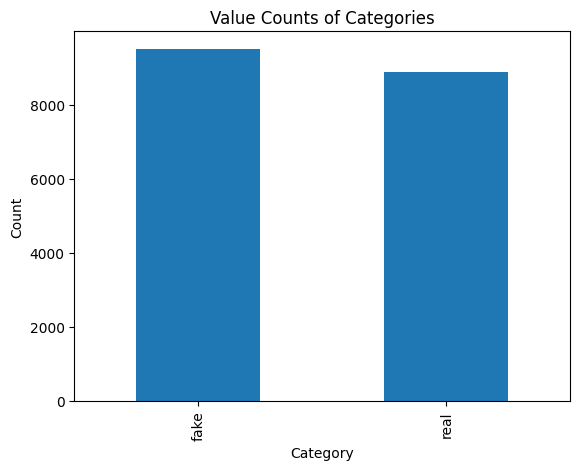

In [12]:
fake_real_count = df['label'].value_counts()
fake_real_count.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of Categories')
plt.show()

# Statistical Method 2 – Visualizing Duration Distribution with Matplotlib

To better understand how audio duration differs between real and fake samples, we use matplotlib to plot a box and whisker plo of the `duration` feature grouped by label.

When looking at the boxplot for the duration goruped by the audio clips, we can see that both types share a similar median which is around 2 second clips. However there are some outliers as seen by the second plot that can go more than 20 seconds (for the real type).

Such outliers would cause some issues down the line if we do not exclude them, as our model might be trained that the longer the clip the mroe likely it is real, which is untrue. This can be concluded because for the fake plot, the outliers do not exceed 6 seconds (unlike the real), yet they do go as low as 0.1 seconds unlike the real clips.

Another conclusion we can observe is that for the real clips there is a much tighter quartile range, unlike the fake ones which vary more widely.

---

/tmp/ipython-input-131-3143717109.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
/tmp/ipython-input-131-3143717109.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])


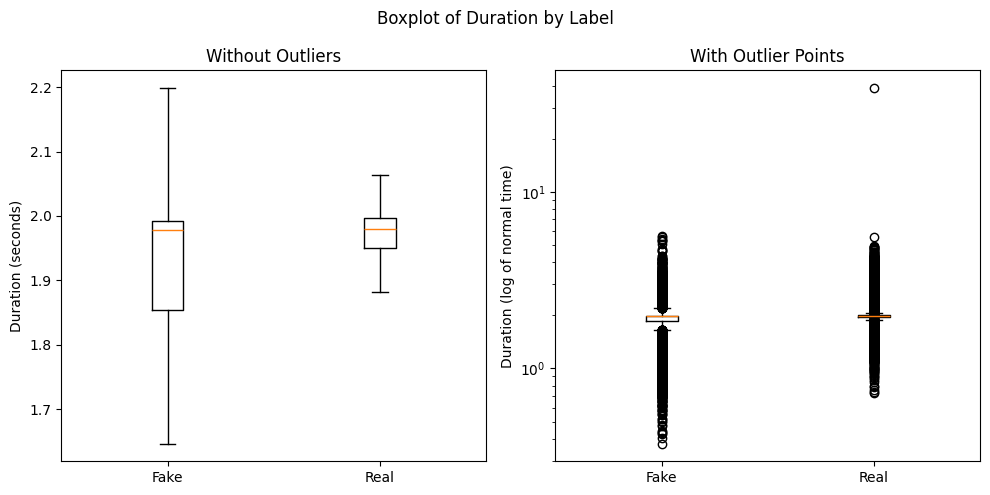

In [131]:
grouped_label_duration = [df[df["label"] == "fake"]["duration"], df[df["label"] == "real"]["duration"]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
axs[0].set_title("Without Outliers")
axs[0].set_ylabel("Duration (seconds)")

axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])
axs[1].set_title("With Outlier Points")
axs[1].set_ylabel("Duration (log of normal time)")
axs[1].set_yscale("log")

fig.suptitle("Boxplot of Duration by Label")
plt.tight_layout()
plt.show()